In [2]:
import numpy as np
import ufl
from mpi4py import MPI
from dolfinx import mesh, fem, plot
from dolfinx.fem import dirichletbc, locate_dofs_geometrical, Constant, Function, VectorFunctionSpace, FunctionSpace
from dolfinx.mesh import create_box, CellType
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.fem.petsc import NonlinearProblem, LinearProblem
import pyvista

# Electro-mechanics problem tutorial

This python notebook serves as an example to setup a forward solver for the solution of a FEM resolution of an electro-mechanical problem using Fenics.


## Test problem

As a test example, we will model a beam, fixed on one end, kept at ground potential. Another beam, fixed, is kept at a non null potential. The generated electro-static force makes the free beam oscillate around an equilibrium. In this notebook we make a simulation to find the static equilibrium.

### Geometry

Each beam is box-shaped with length $L$ and has a square cross section of width $W$. The gap between the beams is D. The beams are included in a box to simulate an infinite domain.

### Simulation Setup

We set the right-hand side body force per unit volume to: $$ \mathbf{f}=(0,0,0) $$

#### Boundary Conditions

##### Mechanic Domain
- Dirichlet: $u=u_D=(0,0,0)$ at the clamped end, $x=0$. 
- Neuman: $T=(0,0,f_{elec})$ on the lower surface of the beam.
- Neumann: the rest of the boundary is traction free, that is, we set $T=0$ (open boundary conditions).

##### Electric Domain
- Dirichlet: $phi=0$ on the surface of the free beam.
- Dirichlet: $phi=V$ on the surface of the activated beam.
- Neumann: the rest of the boundary has a zero-gradient boundary condition.

We start by defining the physical variables used in the program.

In [1]:
# Constants and material properties
L      = 100.
W      = 1.
E      = 160e9
nu     = 0.22
rho    = 2320.
g      = 9.81
F      = 1e6
gap    = 0.5
height = 1.

mu = E / (2 * (1 + nu))
lambda_ = E * nu / ((1 - 2 * nu) * (1 + nu))
epsilon_0 = 8.854187817e-12  # Permittivity of free space (C^2/(N·m^2))
epsilon_r = 1.0  # Relative permittivity, assuming vacuum or air for simplicity

## Geometry and Mesh Creation

In [3]:
# Domain for Beam 1 (Fixed at a potential)
domain_beam1 = create_box(MPI.COMM_WORLD, [[0.0, 0.0, 0.0], [L, W, W]], [20, 5, 5], CellType.hexahedron)

# Domain for Beam 2 (Free on one end and grounded)
domain_beam2 = create_box(MPI.COMM_WORLD, [[0.0, W + gap, 0.0], [L, 2*W + gap, W]], [20, 5, 5], CellType.hexahedron)


# Mechanical function space for both beams (assuming the same type of analysis for both)
V_mech1 = VectorFunctionSpace(domain_beam1, ("CG", 2))

# Electrical function space defined over a combined or larger encompassing domain that includes the gap
field_box = create_box(MPI.COMM_WORLD, [[-10, -10, -10], [L + 10, 2*W + gap + 10, W + 10]], [40, 10, 10], CellType.hexahedron)
V_elec = FunctionSpace(field_box, ("CG", 1))

  V_mech1 = VectorFunctionSpace(domain_beam1, ("CG", 2))

In file included from libffcx_elements_ccac7b501f5c2305bf0b2b6d0dc2b40a8374a9c0.c:57:
/Users/filippozacchei/anaconda3/envs/fenicsx-env/include/python3.12/Python.h:23:12: fatal error: 'stdlib.h' file not found
#  include <stdlib.h>
           ^~~~~~~~~~
1 error generated.


VerificationError: CompileError: command '/Users/filippozacchei/anaconda3/envs/fenicsx-env/bin/clang' failed with exit code 1

### Boundary Conditions

As we would like to clamp the boundary at $x=0$, we do this by using a marker function, which locate the facets where is close to zero by machine precision. In addition we set a tag for the boundary on the other end.

In [43]:
def left(x):
    return np.isclose(x[0], 0)
    
def right(x):
    return np.isclose(x[0], L)

fdim = domain.topology.dim - 1
left_facets = mesh.locate_entities_boundary(domain, fdim, left)
right_facets = mesh.locate_entities_boundary(domain, fdim, right)

u_D = np.array([0, 0, 0], dtype=default_scalar_type)
bc = fem.dirichletbc(u_D, fem.locate_dofs_topological(V, fdim, left_facets), V)


In [44]:
# Concatenate and sort the arrays based on facet indices. Left facets marked with 1, right facets with two
marked_facets = np.hstack([left_facets, right_facets])
marked_values = np.hstack([np.full_like(left_facets, 1), np.full_like(right_facets, 2)])
sorted_facets = np.argsort(marked_facets)
facet_tag = mesh.meshtags(domain, fdim, marked_facets[sorted_facets], marked_values[sorted_facets])

As we want the traction over the remaining boundary to be $0$, we create a dolfinx.Constant

In [45]:
T = fem.Constant(domain, default_scalar_type((0, 0, F)))

We also want to specify the integration measure $ds$, which should be the integral over the boundary of our domain. We do this by using ufl, and its built in integration measures

In [46]:
metadata = {"quadrature_degree": 4}
ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tag, metadata=metadata)
dx = ufl.Measure("dx", domain=domain, metadata=metadata)


## Variational formulation

We are now ready to create our variational formulation in close to mathematical syntax, as for the previous problems.

In [47]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# Deformation gradient
def F(u):
    return (ufl.Identity(len(u)) + ufl.grad(u))

def epsilon(u):
    return ufl.sym(ufl.grad(u))  # Equivalent to 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)

def sigma(u):
    return lambda_ * ufl.nabla_div(u) * ufl.Identity(len(u)) + 2 * mu * epsilon(u)

def S(u):
    return 2.0 * mu * epsilon(u) + lambda_ * ufl.tr(epsilon(u)) * ufl.Identity(len(u))

def P(u):
    return S(u)

f = fem.Constant(domain, default_scalar_type((0, 0, 0)))
a = ufl.inner(P(u),ufl.nabla_grad(v)) * dx
L = ufl.dot(f, v) * dx + ufl.dot(T, v) * ds(2)

## Solve the linear variational problem

We now assemble the matrix and right hand side vector and use PETSc to solve our variational problem



In [48]:
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu", "ksp_rtol": 1e-32})
uh = problem.solve()
print(F(uh))

I


In [49]:
print(dx)

dx(subdomain_id=everywhere, domain=<Mesh #4>, metadata={'quadrature_degree': 4})


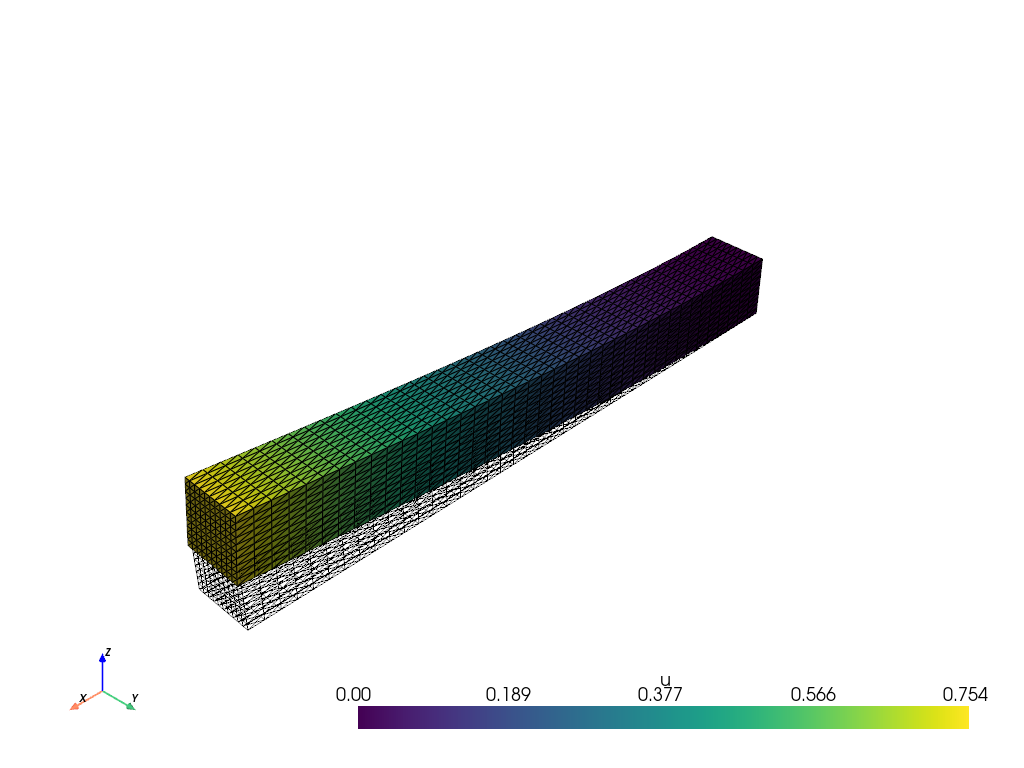

In [50]:
pyvista.start_xvfb()

# Create plotter and pyvista grid
p = pyvista.Plotter()
topology, cell_types, geometry = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Attach vector values to grid and warp grid by vector
grid["u"] = uh.x.array.reshape((geometry.shape[0], 3))
actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=1e0)
actor_1 = p.add_mesh(warped, show_edges=True)
p.show_axes()
if not pyvista.OFF_SCREEN:
    p.show()
else:
    figure_as_array = p.screenshot("deflection.png")